In [51]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
#import matplotlib, copy, skimage, os, tifffile
from skimage import io, morphology, draw
import gdal
from PIL import Image
import random
from skimage.filters.rank import median
from skimage.morphology import disk
import json
from tqdm import tqdm

In [52]:
fname = '../just_buildings_w_uid_second_round.geojson'
#fname = '../added_non_damaged_cleaned.geojson'
coords, chips, classes, uids = wv.get_labels_w_uid(fname)

100%|██████████| 10770/10770 [00:00<00:00, 82683.98it/s]


In [69]:
# draw boxs that specify index number on each bboxes

import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# draw bboxes with bbox uid

def draw_bboxes_withindex(img,boxes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 40)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        draw.text((xmin-70, ymin-20), str(int(uids[idx])), font = font, fill = "orange")
        idx= idx+1
    return source



/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/ubuntu/anyan/harvey_data/filtered_converted_image/20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif


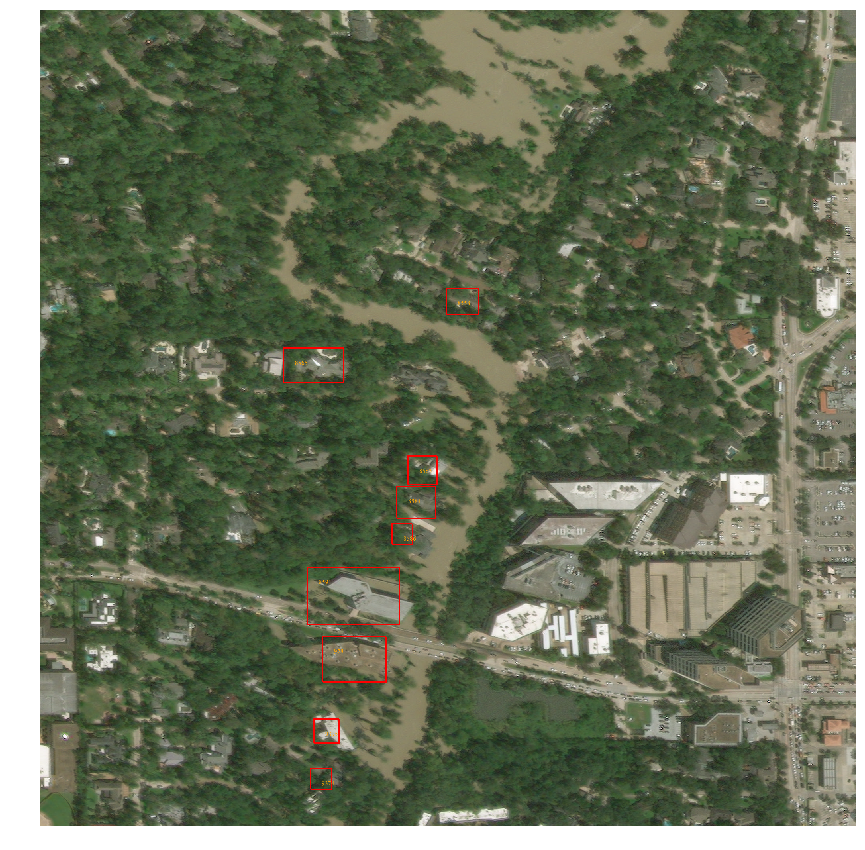

In [70]:
#Load an image
path = '/home/ubuntu/anyan/harvey_data/filtered_converted_image/'
#chip_name = '20170829_1040010032211E00_2112023_jpeg_compressed_10_10.tif' # with blackout
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_01.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_04_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_02.tif'
chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_05_04.tif'
#chip_name = '20170831_105001000B95E100_3020021_jpeg_compressed_06_02.tif'

#chip_name = '20170902_105001000B9D7F00_3030321_jpeg_compressed_07_03.tif'
#chip_name = '20170902_105001000B9D7E00_3030211_jpeg_compressed_07_09.tif'
#chip_name = '20170901_1030010070C13600_3030230_jpeg_compressed_02_07.tif'

chip_fullname = path + chip_name
print(chip_fullname)
arr = wv.get_image(chip_fullname)
coords_chip = coords[chips==chip_name]
classes_chip = classes[chips==chip_name].astype(np.int64)
uids_chip = uids[chips == chip_name].astype(np.int64)
#labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
labelled = aug.draw_bboxes_withindex(arr,coords_chip, uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [71]:
# from PIL import Image
# # np.array(Image.open(fname))
# #I = plt.imread(chip_name)
# im = Image.open(chip_name)
# # im.show()
# imarray = np.array(im)
# print(imarray.shape)
# #print(I.shape)

In [72]:
# #Loading our labels
# coords, chips, classes = wv.get_labels('/home/ubuntu/anyan/harvey_data/toy_data/test2.geojson')
# #We only want to coordinates and classes that are within our chip
# coords = coords[chips==chip_name]
# classes = classes[chips==chip_name].astype(np.int64)

In [73]:
classes

array([1., 1., 1., ..., 1., 1., 1.])

In [74]:
np.any(classes ==73)

False

In [75]:
#Load the class number -> class string label map
# labels = {}
# with open('/home/ubuntu/anyan/harvey_data/toy_data/xview_class_labels.txt') as f:
#     for row in csv.reader(f):
#         labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [76]:
# print(labels[11])

In [77]:
#We can find which classes are present in this image
#print([labels[i] for i in np.unique(classes)])

In [86]:
# changed this function to discard bboxes that cut off to have less than 30 pixels in w/h 
def chip_image_with_uid(img,coords,classes,uids, shape=(300,300)):
    """
    Chip an image and get relative coordinates and classes.  Bounding boxes that pass into
        multiple chips are clipped: each portion that is in a chip is labeled. For example,
        half a building will be labeled if it is cut off in a chip. If there are no boxes,
        the boxes array will be [[0,0,0,0]] and classes [0].
        Note: This chip_image method is only tested on xView data-- there are some image manipulations that can mess up different images.
    Args:
        img: the image to be chipped in array format
        coords: an (N,4) array of bounding box coordinates for that image
        classes: an (N,1) array of classes for each bounding box
        shape: an (W,H) tuple indicating width and height of chips
    Output:
        An image array of shape (M,W,H,C), where M is the number of chips,
        W and H are the dimensions of the image, and C is the number of color
        channels.  Also returns boxes and classes dictionaries for each corresponding chip.
    """
    height,width,_ = img.shape
    wn,hn = shape
    
    w_num,h_num = (int(width/wn),int(height/hn))
    images = np.zeros((w_num*h_num,hn,wn,3))
    total_boxes = {}
    total_classes = {}
    total_uids = {}
    
    # debug
    threshold = 20  # threshold of # of pixels to discard bbox
    
    k = 0
    for i in range(w_num):
        for j in range(h_num):
            x = np.logical_or( np.logical_and((coords[:,0]<((i+1)*wn)),(coords[:,0]>(i*wn))),
                               np.logical_and((coords[:,2]<((i+1)*wn)),(coords[:,2]>(i*wn))))
            out = coords[x]
            y = np.logical_or( np.logical_and((out[:,1]<((j+1)*hn)),(out[:,1]>(j*hn))),
                               np.logical_and((out[:,3]<((j+1)*hn)),(out[:,3]>(j*hn))))
            outn = out[y]
            out = np.transpose(np.vstack((np.clip(outn[:,0]-(wn*i),0,wn),
                                          np.clip(outn[:,1]-(hn*j),0,hn),
                                          np.clip(outn[:,2]-(wn*i),0,wn),
                                          np.clip(outn[:,3]-(hn*j),0,hn))))
            
            box_classes = classes[x][y]
            box_uids = uids[x][y]
            
            # debug
            # remove bboxes that only have less than 20 pixels in w/h left in the image
            # only loop through ones that have 0 or wn/hn in the 4 coordinates
            rows_to_delete = list()
            for m in range(out.shape[0]):
                if(np.any([out[m] == 0]) or np.any([out[m] == wn]) or np.any([out[m] == hn])):
                    # see whether the width of bbox is less than 10 pixels?
                    bbox_w = out[m][2] - out[m][0]
                    bbox_h = out[m][3] - out[m][1]
                    if bbox_w < threshold or bbox_h < threshold:
                        rows_to_delete.append(m)
                        
            # discard this bbox
        
            out = np.delete(out, rows_to_delete, axis=0)
            box_classes = np.delete(box_classes, rows_to_delete, axis=0)
            box_uids = np.delete(box_uids, rows_to_delete, axis=0)
            
            
            if out.shape[0] != 0:
                total_boxes[k] = out
                total_classes[k] = box_classes
                total_uids[k] = box_uids
            else:
                total_boxes[k] = np.array([[0,0,0,0]])
                total_classes[k] = np.array([0])
                total_uids[k] = np.array([0])
            
            chip = img[hn*j:hn*(j+1),wn*i:wn*(i+1),:3]
            #chip = img[wn*i:wn*(i+1),hn*j:hn*(j+1),:3]
            images[k]=chip
            
            k = k + 1
    
    return images.astype(np.uint8),total_boxes,total_classes, total_uids


In [87]:
def chip_image(img, chip_size=(300,300)):
    """
    Segmzent an image into NxWxH chips

    Args:
        img : Array of image to be chipped
        chip_size : A list of (width,height) dimensions for chips

    Outputs:
        An ndarray of shape (N,W,H,3) where N is the number of chips,
            W is the width per chip, and H is the height per chip.

    """
    width,height,_ = img.shape
    wn,hn = chip_size
    images = np.zeros((int(width/wn) * int(height/hn),wn,hn,3))
    k = 0
    for i in tqdm(range(int(width/wn))):
        for j in range(int(height/hn)):
            
            chip = img[wn*i:wn*(i+1),hn*j:hn*(j+1),:3]
            images[k]=chip
            
            k = k + 1
    
    return images.astype(np.uint8)

In [88]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls, c_uid = chip_image_with_uid(img = arr, coords= coords_chip, classes=classes_chip, uids = uids_chip, shape=(512,512))
print("Num Chips: %d" % c_img.shape[0])

# c_img = chip_image(img = arr, chip_size=(512,512))
# print("Num Chips: %d" % c_img.shape[0])



Num Chips: 16


In [89]:
x = np.array([[1,2,3],
        [4,5,6],
        [7,8,9]])

delete = [0,1]
x = np.delete(x, delete, axis=0)
print(x)

[[7 8 9]]


In [90]:
c_img[7].shape

(512, 512, 3)

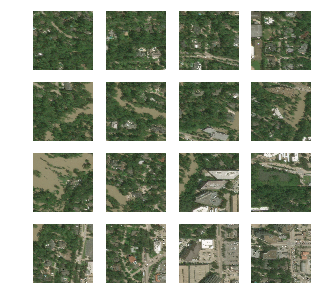

In [91]:
#We can plot some of the chips
fig,ax = plt.subplots(4)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(16):
    plt.subplot(4,4,k+1)
    plt.axis('off')
    plt.imshow(c_img[k])

plt.show()

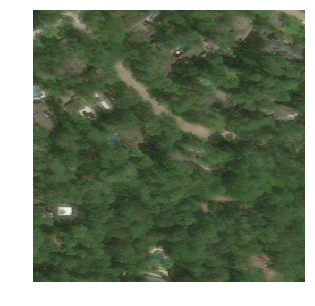

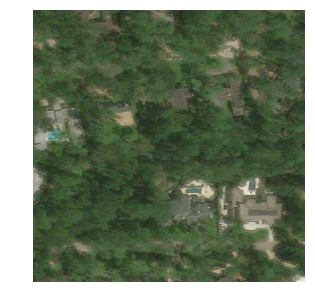

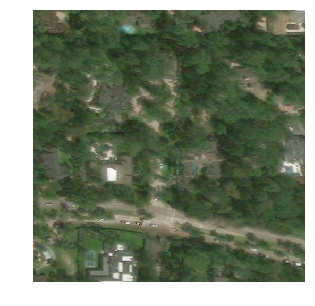

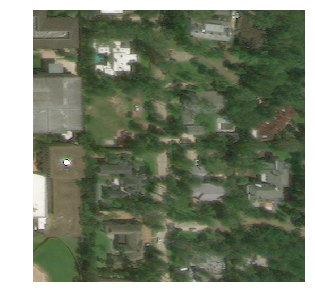

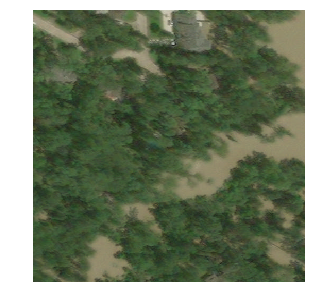

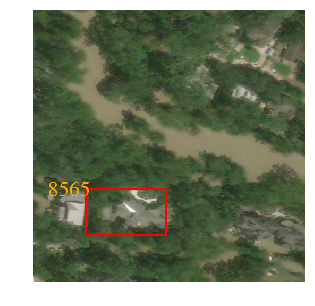

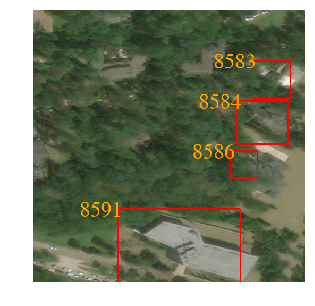

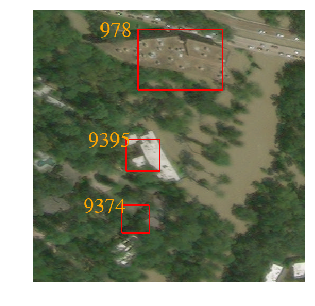

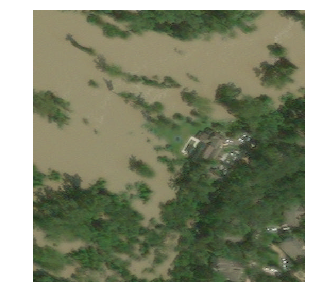

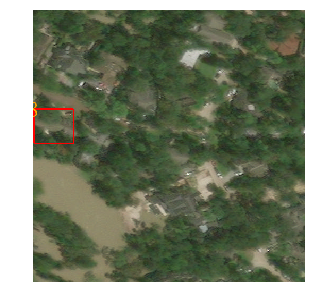

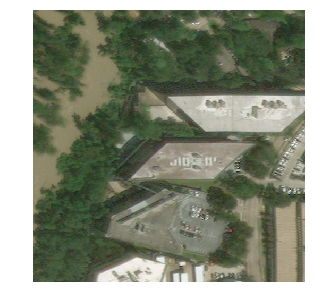

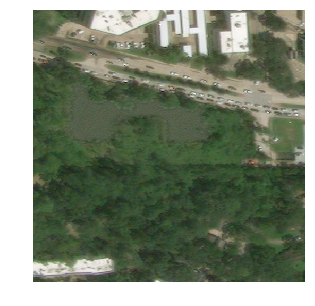

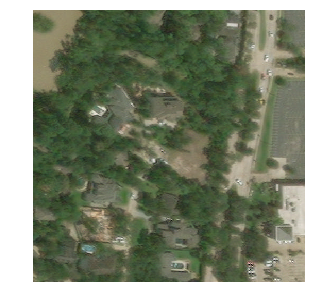

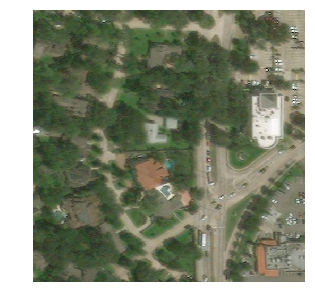

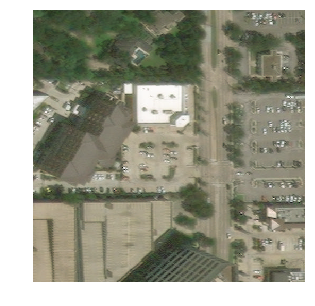

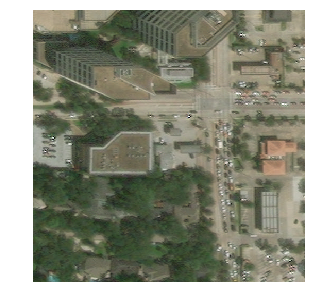

In [92]:
#We can visualize the chips with their labels
for ind in range(16):
    #ind = np.random.choice(range(c_img.shape[0]))
    labelled = draw_bboxes_withindex(c_img[ind],c_box[ind], c_uid[ind])
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(labelled)

In [18]:
ind = 5
c_box[ind]

array([[ 98., 335., 249., 422.]])

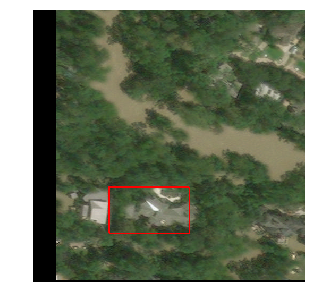

In [19]:
#We can shift the chips
i1,b1,c1 = aug.shift_image_formatted(c_img[ind],c_box[ind], c_cls[ind])
a1 = aug.draw_bboxes(i1,b1)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a1)

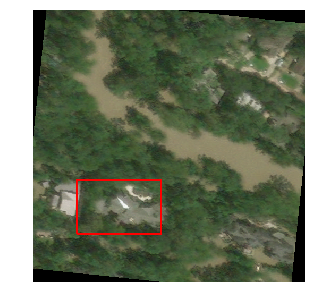

In [20]:
#We can rotate the chips
center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i2,b2,c2 = aug.rotate_image_and_boxes_formatted(c_img[ind], c_box[ind], c_cls[ind])
#i2_flip = i2[:, ::-1]
a2 = aug.draw_bboxes(i2,b2)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a2)

In [21]:
#There are other augmentations available in 'aug_util.py'
#From here, you can save out the chipped images to a TFRecord or other medium
#Use 'process_wv.py' to create a TFRecord file from xView imagery

# test customized data augmentation #

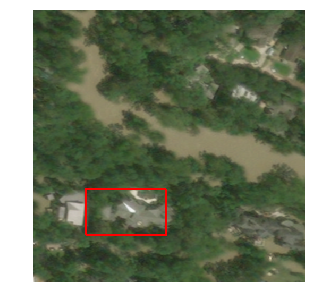

In [22]:
#We can change brightness the chips
#center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
from skimage import data, exposure, img_as_float

# def change_brightness(img):

#     newimg = np.copy(img)
#     #image = img_as_float(newimg)
#     gamma_val  = random.uniform(0.1,5)
#     newimg = exposure.adjust_gamma(img, gamma=gamma_val, gain=0.9)
#     return newimg

i3, b3, c3 = aug.gaussian_blur_formatted(c_img[ind], c_box[ind],  c_cls[ind])
i3 = i3.astype(np.uint8)
# Image needs unsigned bytes,
# i3 means signed bytes. If the sign is irrelevant (all values between 0 and 127), then this will work:
#svimg=im.fromarray(data.astype('uint8'))
#source = Image.fromarray(i3.astype(np.uint8))
a3 = aug.draw_bboxes(i3,c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a3)

[51 50 47 45 42 39 37 35 39 39]
[51.43593576 48.90470575 46.85022032 44.2000766  42.47071741 38.58058453
 36.54450112 35.21468538 38.96910251 37.47159682]


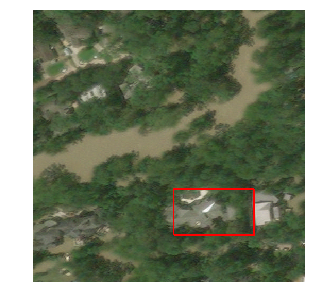

In [23]:
from skimage.transform import rescale
from skimage.util import random_noise
center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i4, b4, c4= aug.horizontal_flip(c_img[ind],  c_box[ind], c_cls[ind])
i4 = i4.astype(np.uint8)
#image_rescaled = rescale(i4, 0.2)
#image_rescaled= image_rescaled.astype(np.uint8)
#i4 = i4[50: 300, 50: 300]
# Image needs unsigned bytes,
# i3 means signed bytes. If the sign is irrelevant (all values between 0 and 127), then this will work:
#svimg=im.fromarray(data.astype('uint8'))
#source = Image.fromarray(i3.astype(np.uint8))
#i4 = random_noise(i4, clip = False)
print(i4[0, :10, 0])
mean = 0
var = 1
noise = np.random.normal(mean, var,
                                 i4.shape)

i4 = i4 + noise
print(i4[0, :10, 0])
i4 = i4.astype(np.uint8)
a4 = aug.draw_bboxes(i4,b4)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a4)

class not in this chip, clipping center part of the chip
shape: (512, 512, 3)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


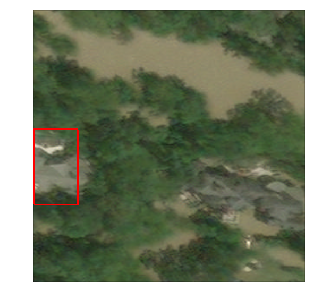

In [24]:
from skimage.transform import rescale, resize, downscale_local_mean, pyramid_expand

center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i5, b5, cls5= aug.zoomin(c_img[ind], c_box[ind], c_cls[ind], 18)  # marine time vessels
i5 = i5.astype(np.uint8)
print('shape:', i5.shape)

# Image needs unsigned bytes,
# i3 means signed bytes. If the sign is irrelevant (all values between 0 and 127), then this will work:
#svimg=im.fromarray(data.astype('uint8'))
#source = Image.fromarray(i3.astype(np.uint8))
# scale = 0.5
# image_rescaled = resize(i5, (500, 500), preserve_range=True)
# enlarge_boxes = []
# for box in b5:
#         xmin, ymin, xmax, ymax = box
#         print(xmin, ymin, xmax, ymax )
#         xmin = xmin * (1/scale)
#         ymin = ymin * (1/scale)
#         xmax = xmax * (1/scale)
#         ymax = ymax * (1/scale)
#         newbox = np.array([xmin, ymin, xmax, ymax]).astype(np.int64)
#         enlarge_boxes.append(newbox)
# image_rescaled = image_rescaled.astype(np.uint8)
# print(image_rescaled.shape)
# a5 = aug.draw_bboxes(image_rescaled,enlarge_boxes)

a5 = aug.draw_bboxes(i5,b5)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a5)

In [25]:
newb5 = np.copy(b5)

In [26]:
# im,box,classes_final= aug.expand_aug_full(c_img[ind], c_box[ind], c_cls[ind], 18)  # marine time vessels

# print(im.shape)
# idx = 62
# i7 = im[idx]
# #print(box)
# b7 = box[idx]
# # print(i6[0,:,0])
# i7 = i7.astype(np.uint8)
# print('shape:', i7.shape)



# a7 = aug.draw_bboxes(i7,b7)
# plt.figure(figsize=(5,5))
# plt.axis('off')
# plt.imshow(a7)

# test expand_aug_random #

random functions to use:  [('vertical_flip',), ('horizontal_flip', 'shift_image_formatted'), ('vertical_flip', 'horizontal_flip', 'zoomin'), ('change_brightness',), ('change_contrast', 'shift_image_formatted', 'rotate_image_and_boxes_formatted'), ('change_contrast', 'zoomin'), ('change_contrast', 'shift_image_formatted'), ('change_contrast', 'rotate_image_and_boxes_formatted'), ('change_brightness', 'zoomin', 'rotate_image_and_boxes_formatted'), ('vertical_flip', 'shift_image_formatted', 'rotate_image_and_boxes_formatted'), ('change_contrast', 'vertical_flip'), ('gaussian_blur_formatted',), ('change_contrast',), ('change_contrast', 'horizontal_flip', 'shift_image_formatted'), ('horizontal_flip', 'shift_image_formatted', 'rotate_image_and_boxes_formatted')]
one image is augmented into:  15
processing round:  0
BBOX invalid height or width
BBOX invalid height or width
processing round:  1
processing round:  2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


BBOX ALL ZEROS
processing round:  3
processing round:  4
processing round:  5
processing round:  6
processing round:  7
processing round:  8
processing round:  9
BBOX invalid height or width
processing round:  10
final augmentation number:  11
(11, 512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)
shape: (512, 512, 3)


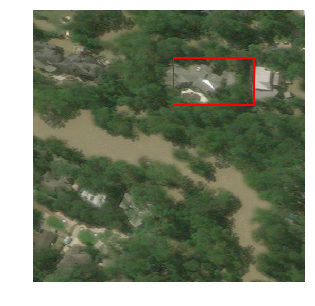

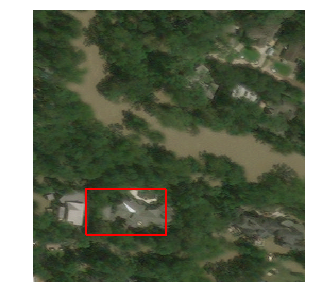

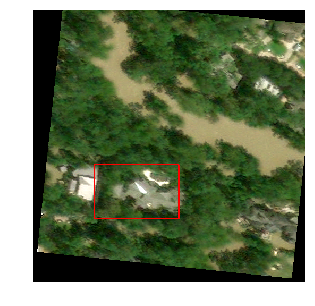

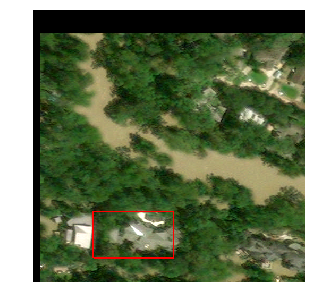

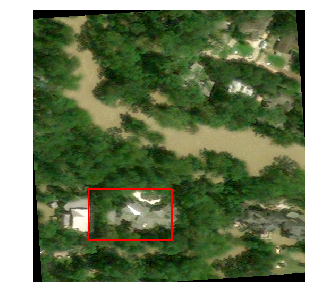

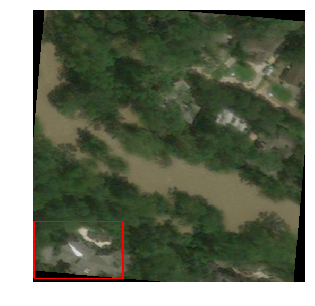

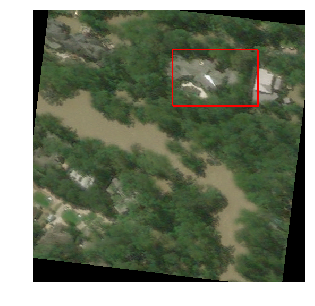

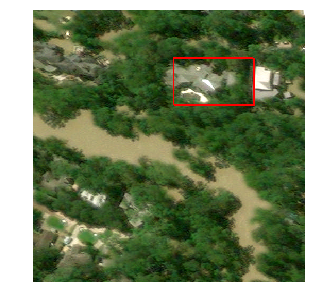

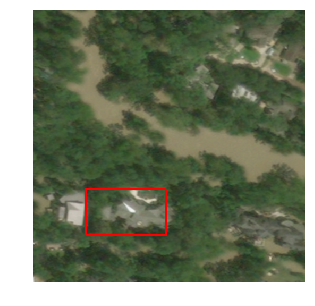

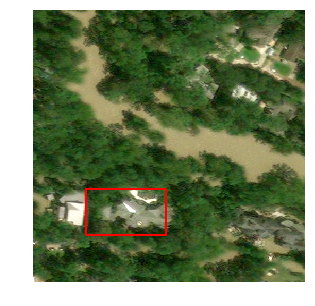

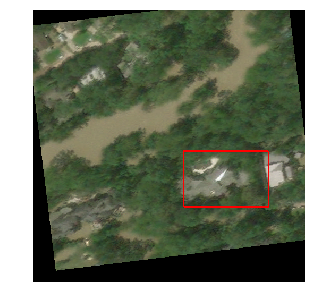

In [37]:
im,box,classes_final= aug.expand_aug_random(c_img[ind], c_box[ind], c_cls[ind], 1)  # marine time vessels

print(im.shape)

for idx in range(0, len(box)):
#     idx = 5
    i8 = im[idx]
    #print(box)
    b8 = box[idx]
    # print(i6[0,:,0])
    i8 = i8.astype(np.uint8)
    print('shape:', i8.shape)



    a8 = aug.draw_bboxes(i8,b8)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(a8)

# deprecated below #

In [28]:
import random
from skimage.transform import rescale, resize
from skimage.util import random_noise
import functools
from itertools import chain, combinations
# generate all possible combinations of sublist of a list 
def all_subsets(lst):
    return chain(*map(lambda x: combinations(lst, x), range(0, len(lst)+1)))



# gamma correction: see http://scikimgt-image.org/docs/dev/api/skimage.exposure.html 
# For gamma greater than 1, the histogram will shift towards left and the output image will be darker than the input image.
def change_brightness(img, boxes, classes):

    newimg = np.copy(img)
    #image = img_as_float(newimg)
    gamma_val  = random.uniform(0.1,2)
    newimg = exposure.adjust_gamma(img, gamma=gamma_val, gain=0.9)
    return newimg, boxes, classes


def change_contrast(img, boxes, classes):
    newimg = np.copy(img)
    v_min, v_max = np.percentile(img, (0.2, 99.8))
    newimg= exposure.rescale_intensity(img, in_range=(v_min, v_max))

    return newimg, boxes, classes


# def vertical_flip(img,  boxes, classes):
#     pivot = np.array([int(img.shape[0]/2),int(img.shape[1]/2)])
#     newimg, newboxes = rotate_image_and_boxes(img, 180, pivot, boxes)
#     return newimg, newboxes, classes



def median_blur(img, boxes, classes):
    disk_size = np.random.choice(range(1, 7))
    newimg = np.copy(img)
    for i in range(img.shape[2]):
        newimg[:,:,i] = median(img[:,:,i], disk(5))
    return newimg, boxes, classes



def horizontal_flip(img,  boxes, classes):
    newimg = img[:, ::-1]
    # flip boxes
    pivot = np.array([int(img.shape[0]/2),int(img.shape[1]/2)])
    newboxes = []
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        #The 'x' values are not centered by the x-center (shape[0]/2)
        #but rather the y-center (shape[1]/2)

        xmin = 2 * pivot[1] - xmin
        xmax = 2 * pivot[1] - xmax

        #ymax -= pivot[0]
        '''
        bfull = np.array([ [xmin,xmin,xmax,xmax] , [ymin,ymax,ymin,ymax]])
        c = np.dot(R,bfull)
        c[0] += pivot[1]
        c[0] = np.clip(c[0],0,img.shape[1])
        c[1] += pivot[0]
        c[1] = np.clip(c[1],0,img.shape[0])

        if np.all(c[1] == img.shape[0]) or np.all(c[1] == 0):
            c[0] = [0,0,0,0]
        if np.all(c[0] == img.shape[1]) or np.all(c[0] == 0):
            c[1] = [0,0,0,0]

        newbox = np.array([np.min(c[0]),np.min(c[1]),np.max(c[0]),np.max(c[1])]).astype(np.int64)

        if not (np.all(c[1] == 0) and np.all(c[0] == 0)):
                                                                                       30%
     newboxes.append(newbox)
        '''
        newbox = np.array([xmin, ymin, xmax, ymax]).astype(np.int64)
        newboxes.append(newbox)
    return newimg, newboxes, classes

def gaussian_noise(img, boxes, classes):
    #newimg = random_noise(img, mode='gaussian', seed=None, clip=True, **kwargs)
    mean = 0
    var = 1
    noise = np.random.normal(mean, var,
                                 img.shape)
    newimg = img + noise
    newimg = np.array(newimg.clip(0)).astype(np.uint8)
    #debug
#     print('gaussion noise img shape, ', newimg.shape)
#     print('gaussion noise img , ', newimg[0,:,0])

    return newimg, boxes, classes




def zoomin(img, boxes, classes, class_id):
    # locate a bouding box that contains class_id
    rand  = random.uniform(0.1,5)
    randint = random.randint(1, 10)
    # get a list of bbox indexes of things that of interest
    ind_list = [i for i, x in enumerate(classes) if str(x) == str(class_id)]
    # zoom in a certain scale: 0.5 - 1 of original size
    w = img.shape[0]
    h = img.shape[1]
    # when no index found, gives warning, and crop the center of the image 
    #assert len(ind_list)!=0, "class not in this chip"

    if len(ind_list) ==0:
        #raise ValueError("class not in this chip")
        print('class not in this chip, clipping center part of the chip')
        bbox_x_center = w/2
        bbox_y_center = h /2
    else:
    # randomly get one object to zoom
        ind = np.random.choice(range(len(ind_list)))
         # get bbox center:
        xmin, ymin, xmax, ymax = boxes[ind]
        bbox_x_center = (xmin + xmax)/2
        bbox_y_center = (ymin + ymax) /2


    scale = random.uniform(0.5,1)
    #scale = 0.5
    scaled_x = w * scale  # cropped area width
    scaled_y = h * scale
                                                                                       
    # force the crop to be square and contain the chosen bbox
    if bbox_x_center < 1/2 * w:
         # start from leftmost
        startx = 0
        endx = int(startx + scaled_x)
        # should consider the case: if endx < xmax
        # but in harvey's case, trash heaps/bridges/ roads won't be larger than 150 pixel
    else:
        endx = w
        startx = int(w - scaled_x)
    if bbox_y_center < 1/2 * h:
        starty = 0
        endy = int(starty + scaled_y)
    else:
        endy = h
        starty = int(h - scaled_y)

    # crop a region, centered on the bbox of that ind
    '''
    startx =  int(w - scaled_x/2) if (w - scaled_x/2) > 0 else 0
    starty = int(h - scaled_y/2) if (h - scaled_y/2) > 0 else 0
    endx = w if (w + scaled_x/2) > w else int(w + scaled_x/2)   
    endy = h if (h + scaled_y/2) > h else int(h + scaled_y/2)
    '''
    newimg = img[startx: endx, starty: endy]
    image_rescaled = resize(newimg, (w, h), preserve_range=True)
    # debug
    print('startx, endx', startx, endx)
    print('starty, endy', starty, endy)
    # scale bounding boxes inside the cropped area
    # see https://github.com/DIUx-xView/data_utilities/blob/master/wv_util.py
    newboxes = []
    newclasses = []
    # crop bboxes and scale them 
    boxes = np.array(boxes)  # change to np array, otherwise, boxes[:,0] cannot access list
    x = np.logical_or( np.logical_and( (boxes[:,0]<endy),  (boxes[:,0]>starty)),
                               np.logical_and((boxes[:,2]<endy),  (boxes[:,2]>starty)))
    # debug
#     print(x)
    out = boxes[x]
    y = np.logical_or( np.logical_and(  (out[:,1]<endx),  (out[:,1]>startx)),
                               np.logical_and((out[:,3]<endx),  (out[:,3]>startx)))
    outn = out[y]
    out = np.transpose(np.vstack((np.clip(outn[:,0]-starty,0,scaled_y),
                                          np.clip(outn[:,1]-startx,0, scaled_x),
                                          np.clip(outn[:,2]-starty,0,scaled_y),
                                          np.clip(outn[:,3]-startx,0, scaled_x))))
    box_classes = classes[x][y]


    if out.shape[0] != 0:
        newboxes = out
        newclasses = box_classes
    else:
        newboxes= np.array([[0,0,0,0]])
        newclasses = np.array([0])

    # now rescale each bouding boxes

    enlarge_boxes = []
    for box in newboxes:
        xmin, ymin, xmax, ymax = box
        xmin = xmin * (1/scale)
        ymin = ymin * (1/scale)
        xmax = xmax * (1/scale)
        ymax = ymax * (1/scale)
        newbox = np.array([xmin, ymin, xmax, ymax]).astype(np.int64)
        enlarge_boxes.append(newbox)


    return image_rescaled,enlarge_boxes,  newclasses



In [29]:
def expand_aug(img, boxes, classes, class_id):
   # func_list = ['change_brightness', 'change_contrast', 'zoomin', 'horizontal_flip', 'gaussian_noise']
    func_list = ['change_contrast','median_blur','zoomin']
    all_subset = all_subsets(func_list)
    # number of augmentation = # of all combinations
    # all_subset contains empty set, so -1
    num_aug = len(list(all_subset)) -1
    # debug
    print('one image is augmented into: ', num_aug)
    # number of different choices of augmentation done to one image
    w,h, _ = img.shape
    images = np.zeros((num_aug,w,h,3))
    total_boxes = {}
    total_classes = {}

   
    # debug
    print('finishing copying')
    k = 0   # k = [0, num_aug)
    for subset in all_subsets(func_list):
        print('subset: ', subset)
        newimg =  np.copy(img)
        newboxes = np.copy(boxes)
        newclasses = np.copy(classes)
        
        len_sub = len(subset)
        
        if len_sub == 0:
            continue
        for idx in range(len_sub):
            if subset[idx] == 'zoomin':
                newimg, newboxes, newclasses = globals()[subset[idx]](newimg, newboxes, newclasses, class_id)
            else:
                newimg, newboxes, newclasses = globals()[subset[idx]](newimg, newboxes, newclasses)
        images[k] = newimg
        total_boxes[k] = newboxes
        total_classes[k] = newclasses
        # debug
        print("processing round: ", k)
        k = k+1

    return images.astype(np.uint8),total_boxes,total_classes


shape: (512, 512, 3)


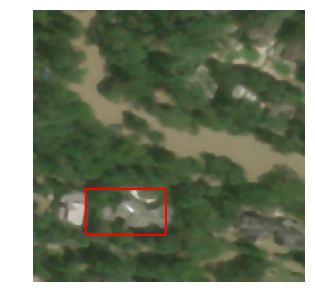

In [30]:
i8, b8, cls8= median_blur(c_img[ind], c_box[ind], c_cls[ind])  # marine time vessels
i8 = i8.astype(np.uint8)
print('shape:', i8.shape)

# Image needs unsigned bytes,
# i3 means signed bytes. If the sign is irrelevant (all values between 0 and 127), then this will work:
#svimg=im.fromarray(data.astype('uint8'))
#source = Image.fromarray(i3.astype(np.uint8))
# scale = 0.5
# image_rescaled = resize(i5, (500, 500), preserve_range=True)
# enlarge_boxes = []
# for box in b5:
#         xmin, ymin, xmax, ymax = box
#         print(xmin, ymin, xmax, ymax )
#         xmin = xmin * (1/scale)
#         ymin = ymin * (1/scale)
#         xmax = xmax * (1/scale)
#         ymax = ymax * (1/scale)
#         newbox = np.array([xmin, ymin, xmax, ymax]).astype(np.int64)
#         enlarge_boxes.append(newbox)
# image_rescaled = image_rescaled.astype(np.uint8)
# print(image_rescaled.shape)
# a5 = aug.draw_bboxes(image_rescaled,enlarge_boxes)

a8 = aug.draw_bboxes(i8,b8)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a8)

one image is augmented into:  7
finishing copying
subset:  ()
subset:  ('change_contrast',)
processing round:  0
subset:  ('median_blur',)
processing round:  1
subset:  ('zoomin',)
class not in this chip, clipping center part of the chip
startx, endx 130 512
starty, endy 130 512
processing round:  2
subset:  ('change_contrast', 'median_blur')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


processing round:  3
subset:  ('change_contrast', 'zoomin')
class not in this chip, clipping center part of the chip
startx, endx 218 512
starty, endy 218 512
processing round:  4
subset:  ('median_blur', 'zoomin')
class not in this chip, clipping center part of the chip
startx, endx 91 512
starty, endy 91 512
processing round:  5
subset:  ('change_contrast', 'median_blur', 'zoomin')
class not in this chip, clipping center part of the chip
startx, endx 105 512
starty, endy 105 512
processing round:  6
(7, 512, 512, 3)
shape: (512, 512, 3)


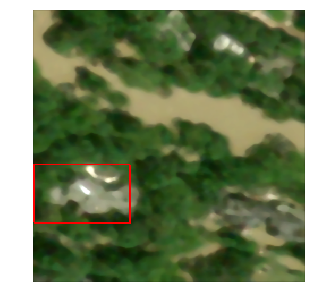

In [31]:
# test augment in batches
im,box,classes_final= expand_aug(c_img[ind], c_box[ind], c_cls[ind], 73)  # marine time vessels
# get a random one
print(im.shape)
idx = 6
i6 = im[idx]
#print(box)
b6 = box[idx]
# print(i6[0,:,0])
i6 = i6.astype(np.uint8)
print('shape:', i6.shape)

a6 = aug.draw_bboxes(i6,b6)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a6)


In [32]:
classes_final[6]

array([1])

In [33]:
np.any(classes_final[6][:]== 73)

False